In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy import stats
import analysis_perDRG
import scikit_posthocs as sp

In [2]:
name = 'd14perDRG_'

with open('D14_SNI_area.json') as f:
    results_sni = json.load(f)
with open('D14_Sham_area.json') as f:
    results_sham = json.load(f)

In [3]:
sham_il = analysis_perDRG.GroupData(results_sham, 'IL', number_of_rats=6)
sham_cl = analysis_perDRG.GroupData(results_sham, 'CL', number_of_rats=6)

sni_il = analysis_perDRG.GroupData(results_sni, 'IL', number_of_rats=6)
sni_cl = analysis_perDRG.GroupData(results_sni, 'CL', number_of_rats=6)

In [4]:
def statistic(group_a_data, group_b_data):
    statistic, p_value_a = stats.shapiro(group_a_data)
    statistic, p_value_b = stats.shapiro(group_b_data)
    
    if (p_value_b < 0.05) or (p_value_a < 0.05):
        # data is not normally distrubuted (<0.05)
        statistic, p_value = stats.mannwhitneyu(group_a_data, group_b_data, alternative='two-sided')
        print('Mann Whitney U: p-value='+"{:.5f}".format(p_value))
    else:
        # data is normally distributed
        # test for equal variance
        statistic, p_value = stats.bartlett(group_a_data, group_b_data)
        if p_value < 0.05:
            # no equal variance
            equal_variance = False
            print('Welch-test')
        else: 
            equal_variance = True
            print('t-test')
        # perform t-test
        statistic, p_value = stats.ttest_ind(group_a_data, group_b_data, equal_var=equal_variance, nan_policy='omit')
        print('p-value='+"{:.5f}".format(p_value))

In [5]:
def statistic_all(feature):
    group_a_data = getattr(sham_il, feature)
    group_b_data = getattr(sham_cl, feature)    
    group_c_data = getattr(sni_il, feature)
    group_d_data = getattr(sni_cl, feature)
    
    # Test for normal distribution
    statistic, p_value_a = stats.shapiro(group_a_data)
    statistic, p_value_b = stats.shapiro(group_b_data)
    statistic, p_value_c = stats.shapiro(group_c_data)
    statistic, p_value_d = stats.shapiro(group_d_data)
    
    if (p_value_b < 0.05) or (p_value_a < 0.05) or (p_value_c < 0.05) or (p_value_d < 0.05):
        # data is not normally distrubuted (<0.05)
        # non-parametric version of ANOVA
        statistic, p_value = stats.kruskal(group_a_data, group_b_data, group_c_data, group_d_data, nan_policy='omit')
        print('Mann Whitney U: p-value='+"{:.5f}".format(p_value))
        #perform posthoc mannwhitney-u
        stat = sp.posthoc_mannwhitney([pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna()])
        
    else:
        # data is normally distributed
        # test for equal variance
        statistic, p_value = stats.bartlett(pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna())
        if p_value < 0.05:
            # no equal variance
            equal_variance = False
            # tests the equality of k independent means in the face of heterogeneity of variance
            i = stats.alexandergovern(group_a_data, group_b_data, group_c_data, group_d_data)
            print(i)
            print('Welch’s t-test: p-value='+"{:.5f}".format(111))
 
        else: 
            #data is normally distributed and have equal variances
            equal_variance = True
            statistic, p_value = stats.f_oneway(pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna())
            print('one-way ANOVA: p-value='+"{:.5f}".format(p_value))
        stat = sp.posthoc_ttest([pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna()], equal_var=equal_variance) 
    
    
    stat.columns = ['Sham_IL', 'Sham_CL', 'SNI_IL', 'SNI_CL']
    stat.index = ['Sham_IL', 'Sham_CL', 'SNI_IL', 'SNI_CL']
    return stat.round(4)

In [6]:
def quick_plot(group_a, group_b, feature):
    group_a_data = getattr(group_a, feature)
    group_b_data = getattr(group_b, feature)    
    
    statistic(group_a_data, group_b_data)
    
    plt.figure(figsize=(4,6))
    sns.boxplot(data=[group_a_data, group_b_data])
    sns.stripplot(data=[group_a_data, group_b_data], jitter=0.2)
    ax = plt.gca()
    ax.set_xticklabels([group_a.name, group_b.name], fontsize=16)
    plt.ylabel(feature, fontsize=16)
    plt.show()

In [7]:
def plot_all(feature, ylabel):
    group_a_data = getattr(sham_il, feature)
    group_b_data = getattr(sham_cl, feature)    
    group_c_data = getattr(sni_il, feature)
    group_d_data = getattr(sni_cl, feature)      
    #statistic(group_a_data, group_b_data)
    
    plt.figure(figsize=(12,8))
    
    labels=['Sham IL', 'Sham CL', 'SNI IL', 'SNI CL']

    c='k'
    alpha=1
    standard_props = {"color":c, "alpha":alpha, "linewidth":5}
    markers= ['D','o']
    line_props = standard_props
    bbox_props = {**standard_props, 'facecolor': 'w', 'edgecolor':c} #dict(edgecolor=c, alpha=alpha, linewidth=5, facecolor='w')
    median_props = standard_props
    cap_props = standard_props
    linewidth = 5
    fontsize = 32
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.tick_params(length=10, width=linewidth)
    if 'tissue area' in ylabel:
        ax.set_ylim([-1, 31])
    elif 'intensities' in ylabel:
        ax.set_ylim([-0.1, 1.01])
    else:
        ax.set_ylim([-1, 101])
    plt.xticks(fontname="Arial", fontsize=fontsize)
    plt.yticks(fontname="Arial", fontsize=fontsize)


    plt.ylabel(ylabel, fontname="Arial", fontsize=34)

    

    sns.boxplot(data=[group_a_data, group_b_data, group_c_data, group_d_data], width=0.5, whiskerprops=line_props, boxprops=bbox_props
                ,capprops=cap_props, medianprops=median_props, fliersize=0)
    sns.stripplot(data=[group_a_data, group_b_data, group_c_data, group_d_data], jitter=0.2, dodge=True, size=8, marker='o', palette='tab20')
    
    ax.set_xticklabels(labels, fontname="Arial", fontsize=34)
    
    plt.savefig('D14 Boxplots/'+name+feature+'.png', bbox_inches = "tight")
    plt.show()

### GFAP rings > 0

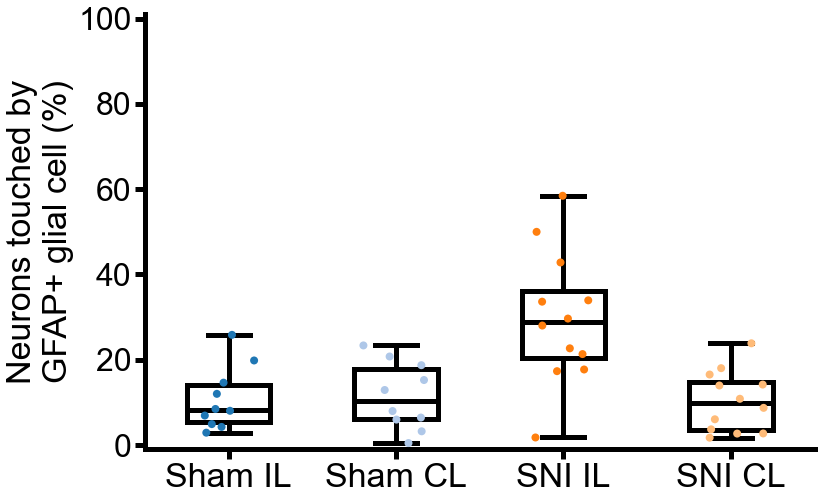

In [8]:
plot_all('ring_ratios_gfap', 'Neurons touched by\nGFAP+ glial cell (%)')

In [9]:
statistic(sni_il.ring_ratios_gfap,sham_il.ring_ratios_gfap)

Welch-test
p-value=0.00165


In [10]:
i = stats.alexandergovern(sni_il.ring_ratios_gfap,sham_il.ring_ratios_gfap,sni_cl.ring_ratios_gfap,sham_cl.ring_ratios_gfap)

In [11]:
i

AlexanderGovernResult(statistic=10.545131756561393, pvalue=0.014457847093151658)

In [12]:
statistic_all('ring_ratios_gfap')

AlexanderGovernResult(statistic=10.545131756561398, pvalue=0.014457847093151618)
Welch’s t-test: p-value=111.00000


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8331,0.0016,0.8672
Sham_CL,0.8331,1.0000,0.0024,0.7013
SNI_IL,0.0016,0.0024,1.0000,0.0012
SNI_CL,0.8672,0.7013,0.0012,1.0000


### GS rings > 0

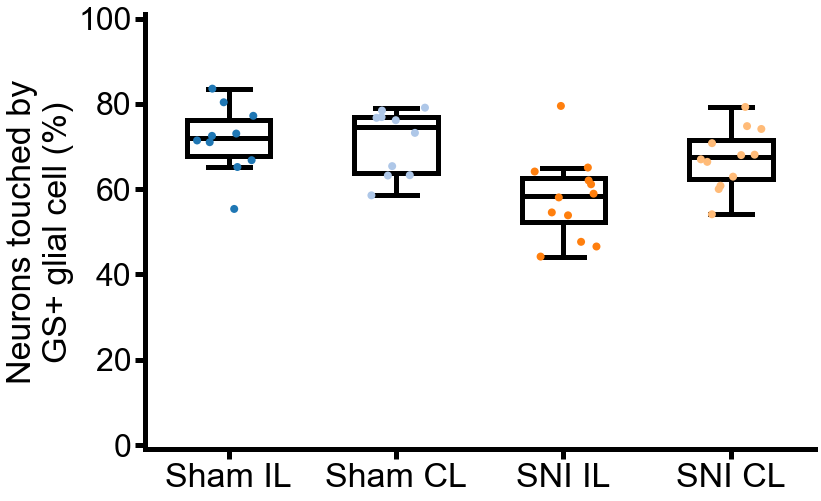

In [13]:
plot_all('ring_ratios_gs', 'Neurons touched by\nGS+ glial cell (%)')

In [14]:
statistic_all('ring_ratios_gs')

one-way ANOVA: p-value=0.00090


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8774,0.0020,0.1816
Sham_CL,0.8774,1.0000,0.0024,0.2278
SNI_IL,0.0020,0.0024,1.0000,0.0143
SNI_CL,0.1816,0.2278,0.0143,1.0000


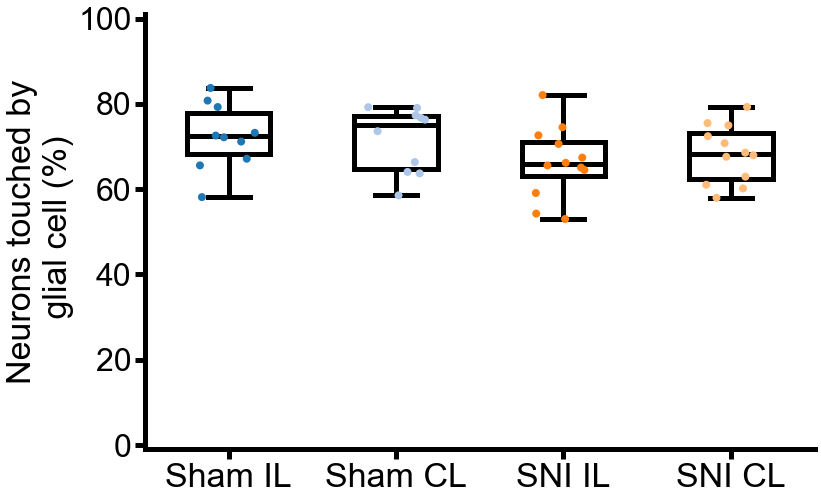

In [15]:
plot_all('ring_ratios_ring', 'Neurons touched by\n glial cell (%)')

In [16]:
statistic_all('ring_ratios_ring')

one-way ANOVA: p-value=0.21547


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7976,0.0887,0.1940
Sham_CL,0.7976,1.0000,0.1400,0.3021
SNI_IL,0.0887,0.1400,1.0000,0.5183
SNI_CL,0.1940,0.3021,0.5183,1.0000


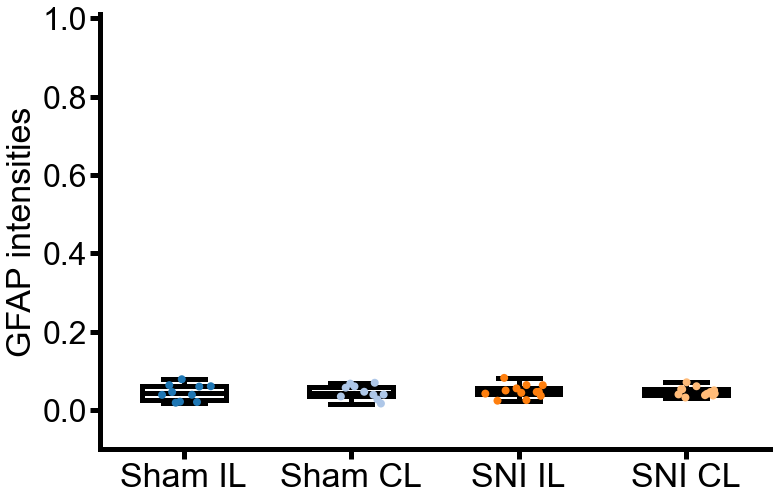

In [17]:
plot_all('gfap_intensities', 'GFAP intensities')

In [18]:
statistic_all('gfap_intensities')

one-way ANOVA: p-value=0.96365


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8977,0.6613,0.7353
Sham_CL,0.8977,1.0000,0.7447,0.8413
SNI_IL,0.6613,0.7447,1.0000,0.8424
SNI_CL,0.7353,0.8413,0.8424,1.0000


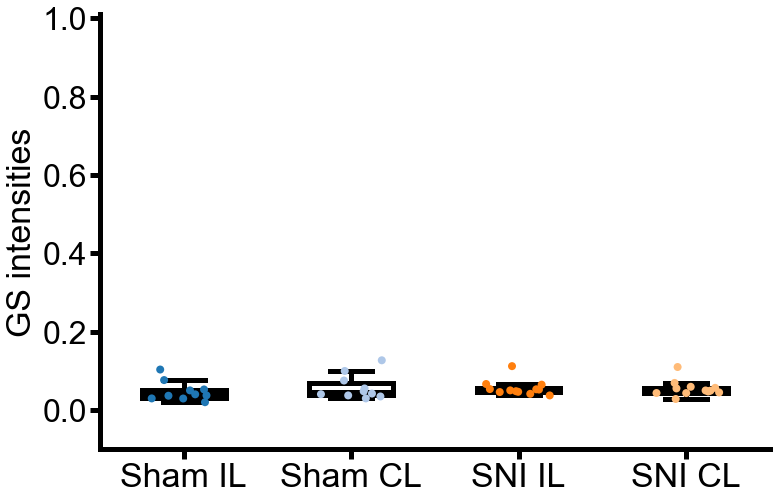

In [19]:
plot_all('gs_intensities', 'GS intensities')

In [20]:
statistic_all('gs_intensities')

Mann Whitney U: p-value=0.40954


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.3447,0.1213,0.2225
Sham_CL,0.3447,1.0000,0.5752,0.5752
SNI_IL,0.1213,0.5752,1.0000,0.8852
SNI_CL,0.2225,0.5752,0.8852,1.0000


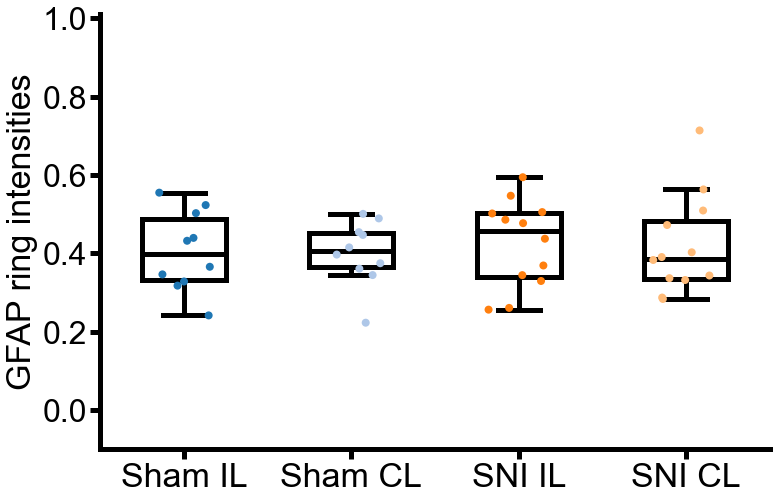

In [21]:
plot_all('gfap_intensities_of_area', 'GFAP ring intensities')

In [22]:
statistic_all('gfap_intensities_of_area')

one-way ANOVA: p-value=0.94435


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9135,0.6591,0.7970
Sham_CL,0.9135,1.0000,0.5612,0.7110
SNI_IL,0.6591,0.5612,1.0000,0.8777
SNI_CL,0.7970,0.7110,0.8777,1.0000


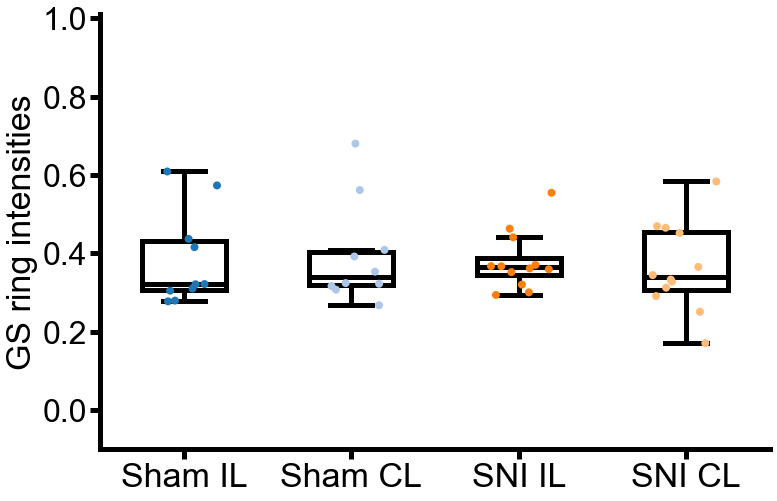

In [23]:
plot_all('gs_intensities_of_area', 'GS ring intensities')

In [24]:
statistic_all('gs_intensities_of_area')

Mann Whitney U: p-value=0.92040


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7337,0.6209,0.8691
Sham_CL,0.7337,1.0000,0.8175,0.8691
SNI_IL,0.6209,0.8175,1.0000,0.5444
SNI_CL,0.8691,0.8691,0.5444,1.0000


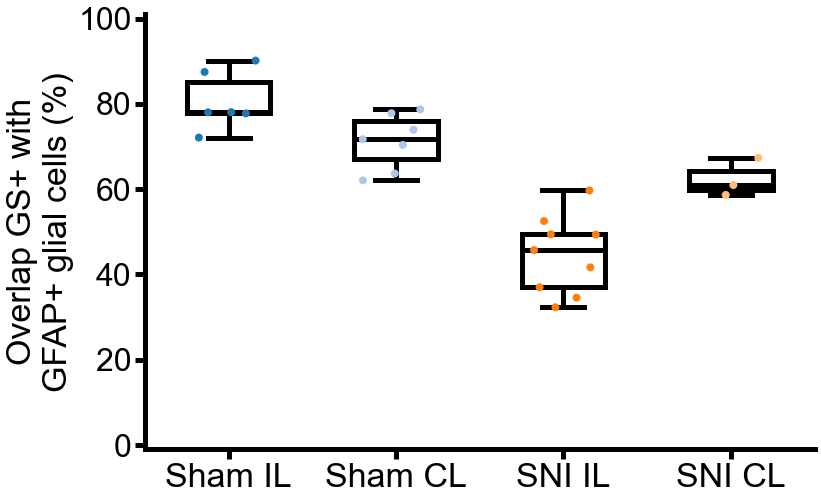

In [25]:
plot_all('gfap_overlaps', 'Overlap GS+ with\nGFAP+ glial cells (%)')

In [26]:
statistic_all('gfap_overlaps')

one-way ANOVA: p-value=0.00000


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.0264,0.0000,0.0043
Sham_CL,0.0264,1.0000,0.0000,0.0650
SNI_IL,0.0000,0.0000,1.0000,0.0101
SNI_CL,0.0043,0.0650,0.0101,1.0000


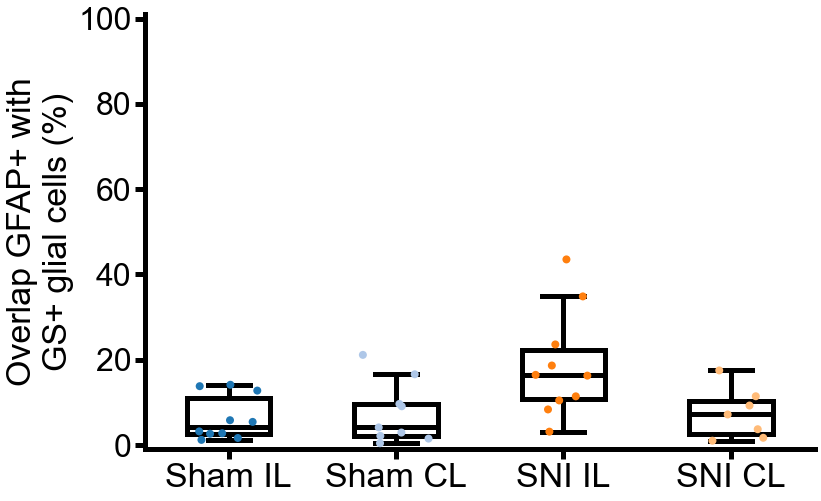

In [27]:
plot_all('gs_overlaps', 'Overlap GFAP+ with\nGS+ glial cells (%)')

In [28]:
statistic_all('gs_overlaps')

Mann Whitney U: p-value=0.03380


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9674,0.0091,0.8125
Sham_CL,0.9674,1.0000,0.0305,0.9182
SNI_IL,0.0091,0.0305,1.0000,0.0431
SNI_CL,0.8125,0.9182,0.0431,1.0000


#### ratio of small neurons vs big neurons
##### maximal small neuron size: diameter=25 µm, area (circular)=491 µm^2 -> 595 pixel
##### minimal neuron size: 246 pixel (based on annotation) --> 202 µm^2

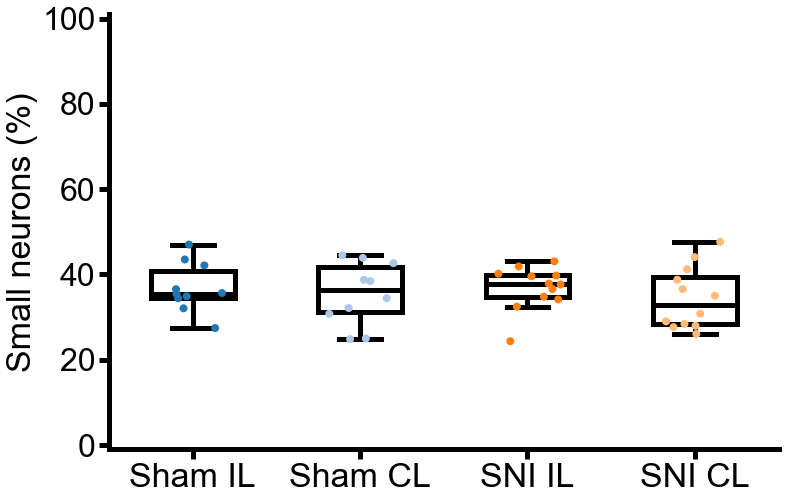

In [29]:
plot_all('small_neurons_percentage', 'Small neurons (%)')

In [30]:
statistic_all('small_neurons_percentage')

one-way ANOVA: p-value=0.75790


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.6475,0.9828,0.3922
Sham_CL,0.6475,1.0000,0.6227,0.7259
SNI_IL,0.9828,0.6227,1.0000,0.3506
SNI_CL,0.3922,0.7259,0.3506,1.0000


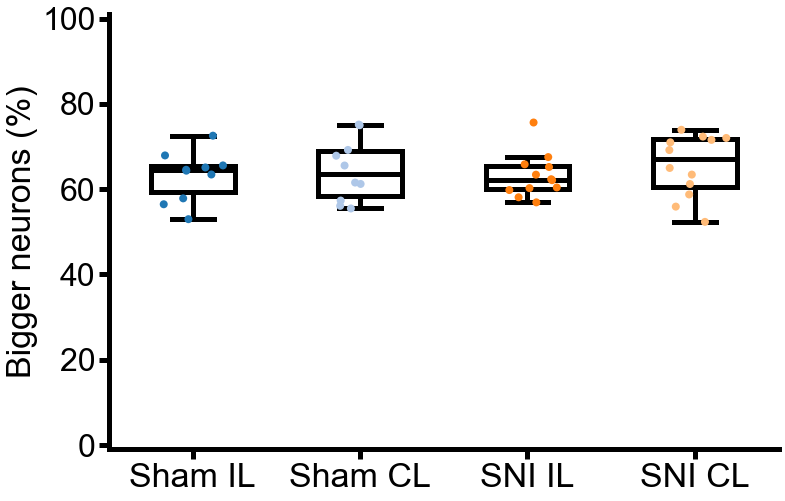

In [31]:
plot_all('bigger_neurons_percentage', 'Bigger neurons (%)')

In [32]:
statistic_all('bigger_neurons_percentage')

one-way ANOVA: p-value=0.75790


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.6475,0.9828,0.3922
Sham_CL,0.6475,1.0000,0.6227,0.7259
SNI_IL,0.9828,0.6227,1.0000,0.3506
SNI_CL,0.3922,0.7259,0.3506,1.0000


In [33]:
stats.kruskal(sham_il.small_neurons_percentage, sham_cl.small_neurons_percentage, sni_il.small_neurons_percentage, sni_cl.small_neurons_percentage)

KruskalResult(statistic=0.9158585858585866, pvalue=0.821599178600634)

In [34]:
stats.f_oneway(sni_il.small_neurons_percentage, sni_cl.small_neurons_percentage, sham_il.small_neurons_percentage, sham_cl.small_neurons_percentage)

F_onewayResult(statistic=0.3941154740089954, pvalue=0.7579037711514445)

In [35]:
sp.posthoc_mannwhitney([sham_il.small_neurons_percentage, sham_cl.small_neurons_percentage, sni_il.small_neurons_percentage, sni_cl.small_neurons_percentage])

,1,2,3,4
1,1.000000,0.791337,0.817483,0.488718
2,0.791337,1.000000,0.817483,0.817483
3,0.817483,0.817483,1.000000,0.340779
4,0.488718,0.817483,0.340779,1.000000


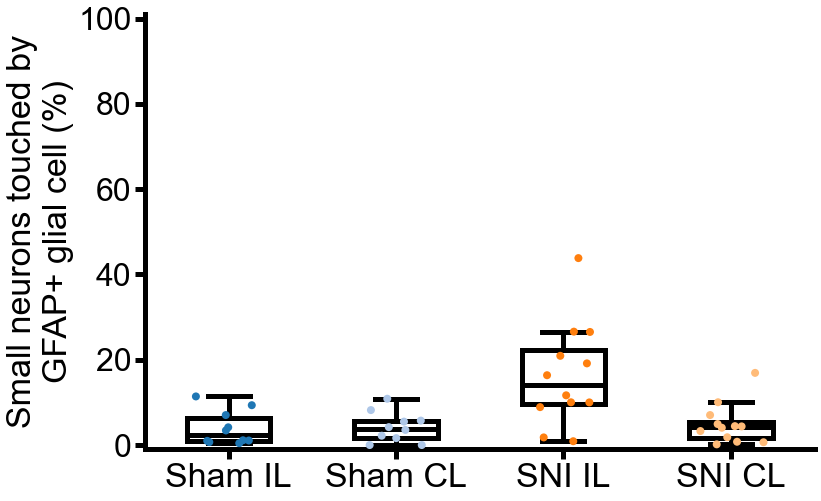

In [36]:
plot_all('small_neurons_gfap_ring', 'Small neurons touched by\nGFAP+ glial cell (%)')

In [37]:
statistic_all('small_neurons_gfap_ring')

Mann Whitney U: p-value=0.00702


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7913,0.0051,0.6682
Sham_CL,0.7913,1.0000,0.0062,0.8690
SNI_IL,0.0051,0.0062,1.0000,0.0086
SNI_CL,0.6682,0.8690,0.0086,1.0000


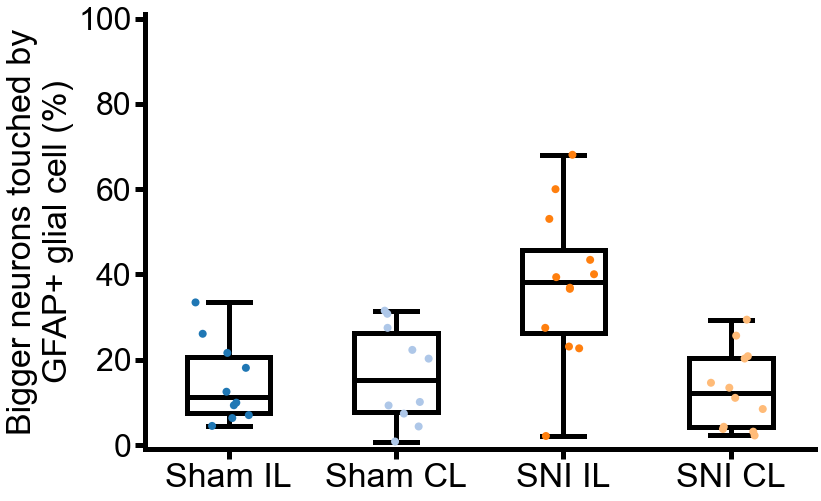

In [38]:
plot_all('bigger_neurons_gfap_ring', 'Bigger neurons touched by\nGFAP+ glial cell (%)')

In [39]:
statistic_all('bigger_neurons_gfap_ring')

one-way ANOVA: p-value=0.00006


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7469,0.0017,0.6622
Sham_CL,0.7469,1.0000,0.0040,0.4576
SNI_IL,0.0017,0.0040,1.0000,0.0003
SNI_CL,0.6622,0.4576,0.0003,1.0000


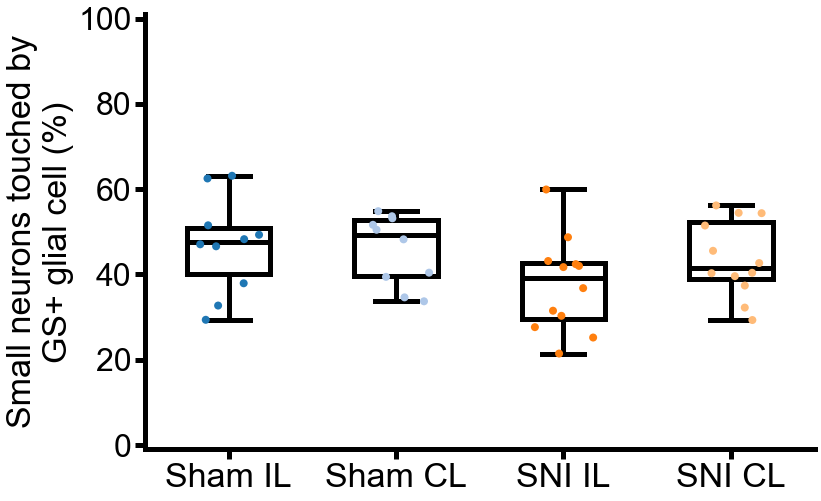

In [40]:
plot_all('small_neurons_gs_ring', 'Small neurons touched by\nGS+ glial cell (%)')

In [41]:
statistic_all('small_neurons_gs_ring')

one-way ANOVA: p-value=0.12523


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8528,0.0641,0.4651
Sham_CL,0.8528,1.0000,0.0574,0.5273
SNI_IL,0.0641,0.0574,1.0000,0.1486
SNI_CL,0.4651,0.5273,0.1486,1.0000


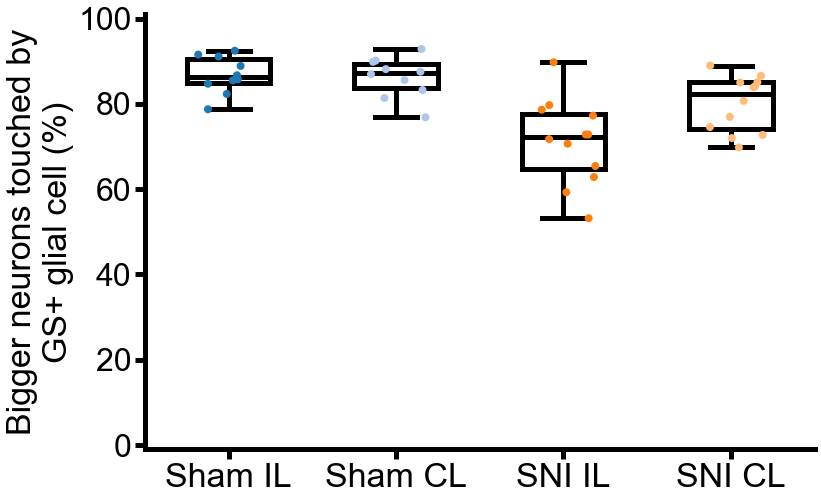

In [42]:
plot_all('bigger_neurons_gs_ring', 'Bigger neurons touched by\nGS+ glial cell (%)')

In [43]:
statistic_all('bigger_neurons_gs_ring')

AlexanderGovernResult(statistic=19.784050399047636, pvalue=0.00018816256975385937)
Welch’s t-test: p-value=111.00000


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8013,0.0002,0.0092
Sham_CL,0.8013,1.0000,0.0002,0.0174
SNI_IL,0.0002,0.0002,1.0000,0.0183
SNI_CL,0.0092,0.0174,0.0183,1.0000


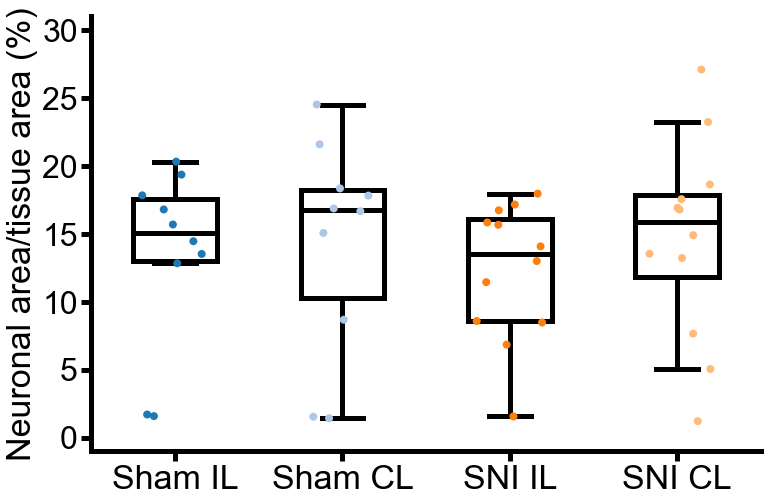

In [44]:
plot_all('neuronal_area_per_tissue', 'Neuronal area/tissue area (%)')

In [45]:
statistic_all('neuronal_area_per_tissue')

Mann Whitney U: p-value=0.64412


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7337,0.4098,0.8175
Sham_CL,0.7337,1.0000,0.2766,0.8691
SNI_IL,0.4098,0.2766,1.0000,0.3408
SNI_CL,0.8175,0.8691,0.3408,1.0000


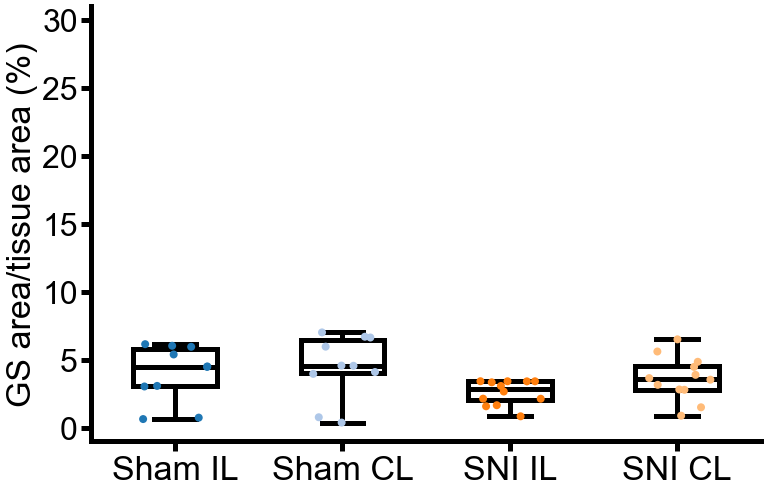

In [46]:
plot_all('gs_area_per_tissue', 'GS area/tissue area (%)')

In [47]:
statistic_all('gs_area_per_tissue')

Mann Whitney U: p-value=0.05662


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.4727,0.1062,0.5752
Sham_CL,0.4727,1.0000,0.0192,0.1765
SNI_IL,0.1062,0.0192,1.0000,0.0606
SNI_CL,0.5752,0.1765,0.0606,1.0000


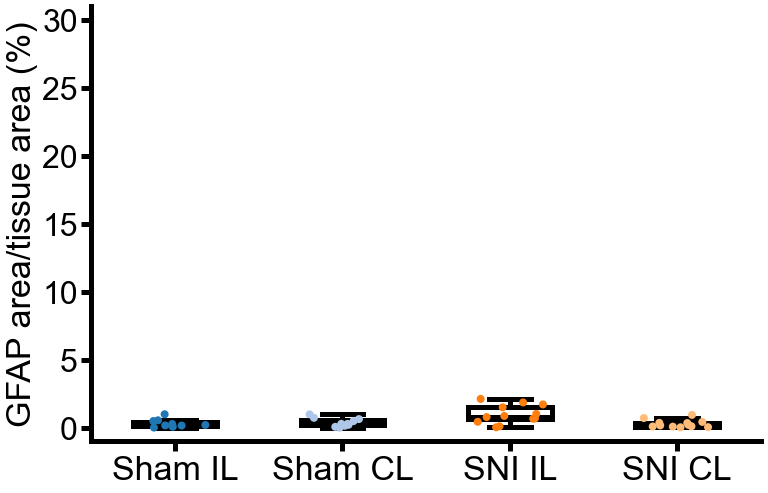

In [48]:
plot_all('gfap_area_per_tissue', 'GFAP area/tissue area (%)')

In [49]:
statistic_all('gfap_area_per_tissue')

Mann Whitney U: p-value=0.02561


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.5708,0.0192,0.8175
Sham_CL,0.5708,1.0000,0.0321,0.4887
SNI_IL,0.0192,0.0321,1.0000,0.0120
SNI_CL,0.8175,0.4887,0.0120,1.0000


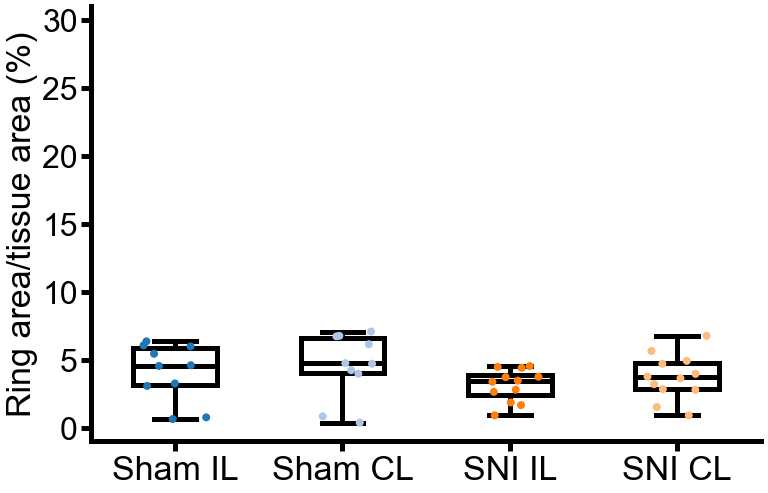

In [50]:
plot_all('ring_area_per_tissue', 'Ring area/tissue area (%)')

In [51]:
statistic_all('ring_area_per_tissue')

one-way ANOVA: p-value=0.33363


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.6322,0.2009,0.6652
Sham_CL,0.6322,1.0000,0.0810,0.3408
SNI_IL,0.2009,0.0810,1.0000,0.3274
SNI_CL,0.6652,0.3408,0.3274,1.0000


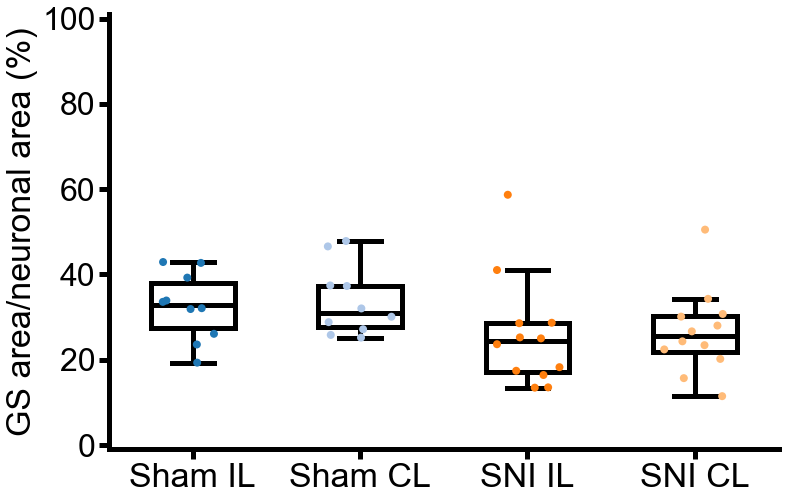

In [52]:
plot_all('gs_area_per_neurons', 'GS area/neuronal area (%)')

In [53]:
statistic_all('gs_area_per_neurons')

Mann Whitney U: p-value=0.04204


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9698,0.0518,0.0927
Sham_CL,0.9698,1.0000,0.0229,0.0602
SNI_IL,0.0518,0.0229,1.0000,0.6650
SNI_CL,0.0927,0.0602,0.6650,1.0000


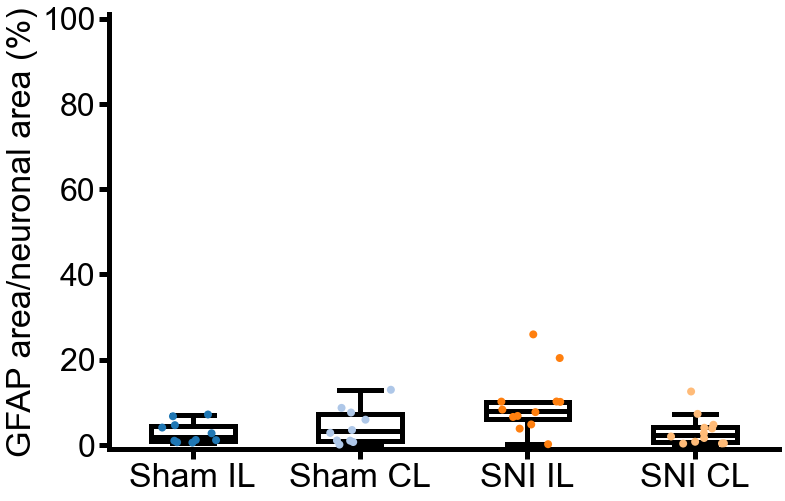

In [54]:
plot_all('gfap_area_per_neurons', 'GFAP area/neuronal area (%)')

In [55]:
statistic_all('gfap_area_per_neurons')

Mann Whitney U: p-value=0.02181


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.5708,0.0076,0.8691
Sham_CL,0.5708,1.0000,0.0518,0.5752
SNI_IL,0.0076,0.0518,1.0000,0.0120
SNI_CL,0.8691,0.5752,0.0120,1.0000


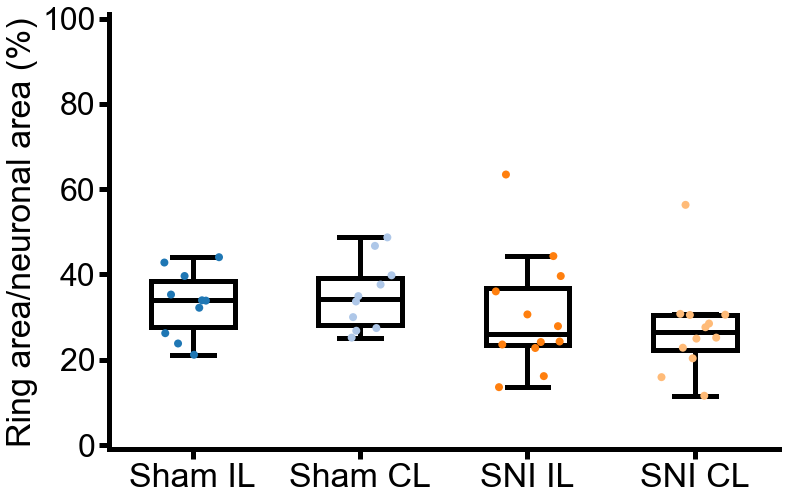

In [56]:
plot_all('ring_area_per_neurons', 'Ring area/neuronal area (%)')

In [57]:
statistic_all('ring_area_per_neurons')

Mann Whitney U: p-value=0.11518


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.6776,0.3734,0.0518
Sham_CL,0.6776,1.0000,0.1563,0.0378
SNI_IL,0.3734,0.1563,1.0000,0.6650
SNI_CL,0.0518,0.0378,0.6650,1.0000


In [58]:
sni_cl.ring_area_per_neurons

[11.564838711751628,
 28.495058083551605,
 22.825240583521953,
 25.191223274015574,
 30.57034228031844,
 30.512785508415774,
 27.630364268867275,
 24.960677627997566,
 20.340234110174165,
 15.919467023549384,
 56.33529111895301,
 30.764860623710838]

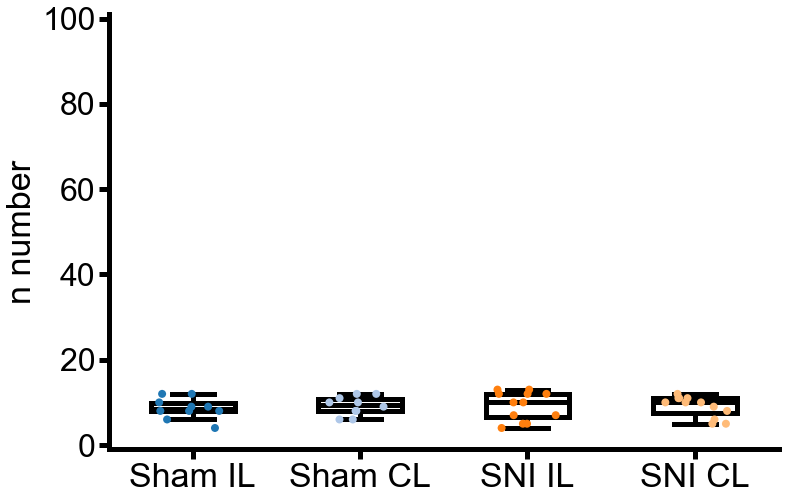

In [59]:
plot_all('n_number', 'n number')

In [60]:
sham_cl.n_number

[9, 12, 11, 12, 6, 10, 10, 6, 8, 8]

In [61]:
sham_cl.ring_ratios_gfap_std

[13.182265532986294,
 15.729631834185165,
 7.220672021746844,
 7.520966628599219,
 1.994952103315416,
 2.6470048475068393,
 14.629547222938136,
 0.47523815775955974,
 3.7872023846306906,
 2.720660573256829]

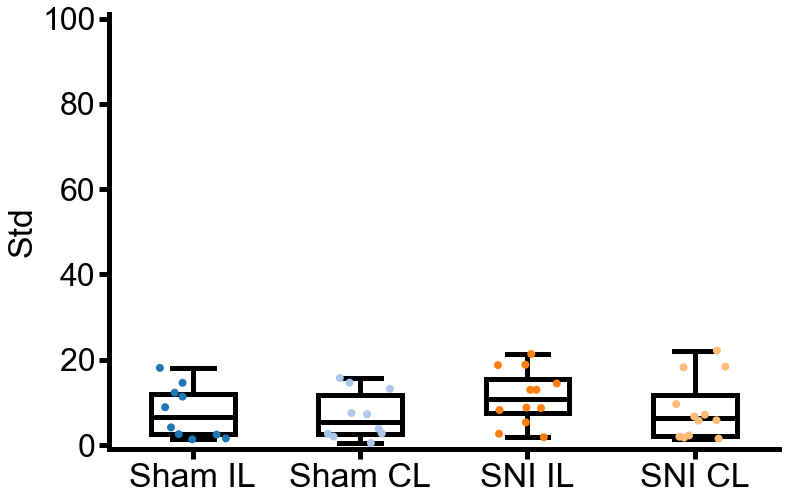

In [62]:
plot_all('ring_ratios_gfap_std', 'Std')